In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import process_outputs as po
import pickle
import os
import copy
import socket
machine = socket.gethostname()
if 'trace' in machine:
    base_fp = '/trace/group/rounce/cvwilson/Output/'
elif os.path.exists('/mnt/d/grid_search/'):
    base_fp = '/mnt/d/grid_search/'
elif os.path.exists('/mnt/e/grid_search/'):
    base_fp = '/mnt/e/grid_search/'
else:
    base_fp = '/home/claire/research/Output/EB/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Create some dictionaries with useful information
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}      # Labels for the different parameters we varied
methodlabels = {'MAE':'MAE','ME':'Bias','RMSE':'RMSE'}                                          # Labels for the different error methods
errorlabels = {'seasonal':'Seasonal mass balance (m w.e.)',                                     # Labels for the different error metrics with units
               'winter':'Winter mass balance (m w.e.)', 
               'summer':'Summer mass balance (m w.e.)', 
               'annual':'Annual mass balance (m w.e.)',
               'snowdepth':'End-of-winter snow depth (m)',
               'snowmass':'End-of-winter snow mass (m w.e.)',
               'snowdensity':'End-of-winter snow density (kg m-3)',
               '2024':'2024 surface height change (m)'} 
shorterrorlabels = {'2024':'2024 surface height','snowdensity':'Snow density','snowdepth':'Snow depth',
                    'seasonal':'Seasonal MB','winter':'Winter MB','summer':'Summer MB','annual':'Annual MB'}
param_labels = {'kw':'Wind factor','kp':'Precipitation factor','c5':'Densification parameter'}
medians = {'kp':'2.6','kw':'1','Boone_c5':'0.024'}                                              # Median value of each of the parameters
sitedict = {'2024':['AB','ABB','B','BD','D','T'],'long':['A','AU','B','D']}                     # Dictionary of sites in the 2024 and long run
all_sites = sitedict['long']+sitedict['2024']+['mean']                                          # List all sites

In [47]:
# USER OPTIONS
method = 'ME'                                                       # Choose from MAE, ME
run_info = {'long':{'date':'02_11', 'idx':'0'},                     # Date and index of the grid search (12_04) (01_16)
            '2024':{'date':'02_12', 'idx':'0'}}                     # (12_06)
params = {'Boone_c5':[0.018,0.02,0.022,0.024,0.026,0.028,0.03], # 
          'kp':[1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5]} # 
for key in params:                                                  # Convert params to strings for processing
    for v,value in enumerate(params[key]):
        params[key][v] = str(value)

In [4]:
for run_type in ['long']: # '2024',
    date = run_info[run_type]['date']
    idx = run_info[run_type]['idx']
    for site in sitedict[run_type][1:]:
        fp = base_fp + f'{date}_{site}_{idx}/'
        for file in os.listdir(fp):
            if '.nc' in file:
                ds,s,e = getds(fp + file)
                years = np.unique(pd.to_datetime(ds.time.values).year)
                nyears_calib = int(len(years) * 0.75)
                split_year = years[0] + nyears_calib 

                # calibration data
                end_calib = pd.to_datetime(f'{split_year}-10-30')
                ds_calibration = ds.sel(time=pd.date_range(s, end_calib, freq='h'))

                # validation data
                start_valid = pd.to_datetime(f'{split_year-1}-08-01')
                ds_validation = ds.sel(time=pd.date_range(start_valid, e, freq='h'))

                # Load the pickle
                stats_fn = fp + file.replace('.nc','.pkl')
                with open(stats_fn, 'rb') as file_stats:
                    results = pickle.load(file_stats)
                
                # Get calibration and validation error
                for set_type in ['calib','valid']:
                    if set_type == 'calib':
                        ds_use = ds_calibration.copy(deep=True)
                    else:
                        ds_use = ds_validation.copy(deep=True)
                    # seasonal mass balance
                    error_dict = seasonal_mass_balance(ds_use,method=['MAE','ME'])
                    winter_MAE, winter_ME = error_dict['winter']
                    summer_MAE, summer_ME = error_dict['summer']
                    annual_MAE, annual_ME = error_dict['annual']
                    seasonal_MAE = np.mean([winter_MAE, summer_MAE])
                    seasonal_ME = np.mean([winter_ME, summer_ME])
                    results[set_type] = {'winter_MAE':winter_MAE,'summer_MAE':summer_MAE,
                            'winter_ME':winter_ME,'summer_ME':summer_ME,
                            'seasonal_MAE':seasonal_MAE,'seasonal_ME':seasonal_ME,
                            'annual_MAE':annual_MAE,'annual_ME':annual_ME}

                    # snowpits
                    for method in ['MAE','ME']:
                        snowpit_dict = snowpits(ds,method=method)
                        for var in snowpit_dict:
                            results[set_type][var] = snowpit_dict[var]

                # Pickle the dict
                with open(stats_fn, 'wb') as file_stats:
                    pickle.dump(results,file_stats)
        print('finished',site)

finished AU
finished B
finished D


In [5]:
# Open results dict
both_dict = {}
for run_type in ['long','2024']: # 
    date = run_info[run_type]['date']
    idx = run_info[run_type]['idx']
    
    # Compiled pickle exists: load it
    with open(base_fp + f'{date}_{idx}_out.pkl', 'rb') as file:
        grid_dict = pickle.load(file)
    
    # Store the dictionary under the run type (long or 2024)
    both_dict[run_type] = grid_dict

# Condense long and 2024 runs into to a single result_dict
result_dict = both_dict['long']
for c5 in params['Boone_c5']:
    for kp in params['kp']:
            # Add the 2024 error stats to the result_dict
            for site in sitedict['2024']:
                # Some sites are different from long run, so add a slot for these runs
                if site not in result_dict[c5][kp]:
                    result_dict[c5][kp][site] = {}
                # Add the 2024 error stats
                for var in both_dict['2024'][c5][kp][site]:
                    result_dict[c5][kp][site]['2024_'+var] = both_dict['2024'][c5][kp][site][var] 

In [6]:
# ===== Find site means of each error type =====
# List out all error types
all_error = list(result_dict['0.026']['2.5']['B'].keys())
all_error.remove('run_no')
all_error.remove('set_no')
all_error.remove('2024_run_no')
all_error.remove('2024_set_no')
    
# Create dictionary to store site means
sites_error_dict = {}
# Loop through all parameters and sites
for c5 in params['Boone_c5']:
    for kp in params['kp']:
        result_dict[c5][kp]['mean'] = {}
        for error_type in all_error:
            sites_error_dict[error_type] = []
            for site in all_sites[:-1]:
                if '2024' in error_type and site in sitedict['2024']:
                    sites_error_dict[error_type].append(result_dict[c5][kp][site][error_type])
                elif '2024' not in error_type and site in sitedict['long']:
                    sites_error_dict[error_type].append(result_dict[c5][kp][site][error_type])
            if len(sites_error_dict[error_type]) > 0:
                result_dict[c5][kp]['mean'][error_type] = np.mean(sites_error_dict[error_type])

In [7]:
# ===== Normalize error between 0-1 for the min-max of a given metric =====
# Set bounds for what we consider a bad run
error_lims = {'2024_MAE_calib':0.5,'snowdensity_MAE_calib':100,'winter_MAE_calib':0.4,'summer_MAE_calib':0.8,'snowdepth_MAE_calib':1,'annual_MAE_calib':1}

# Create storage for minimum/maximum error of each error type
error_extremes_dict = {}
for site in all_sites:
    error_extremes_dict[site] = {}
    for error_type in all_error:
        error_extremes_dict[site][error_type] = {'min':np.inf,'max':0}

# Go through every error and store the extremes
for c5 in params['Boone_c5']:
    for kp in params['kp']:
        for site in all_sites:
            if site in result_dict[c5][kp]:
                for error_type in result_dict[c5][kp][site]:
                    if '_no' not in error_type:
                        current_value = result_dict[c5][kp][site][error_type]

                        # Check if it's a bad run and skip if so
                        if error_type in error_lims:
                            if current_value > error_lims[error_type]:
                                continue
                        else:
                            continue

                        # Acceptable run: compare error metrics to the running extremes
                        if current_value < error_extremes_dict[site][error_type]['min']:
                            error_extremes_dict[site][error_type]['min'] = current_value
                        if current_value > error_extremes_dict[site][error_type]['max']:
                            error_extremes_dict[site][error_type]['max'] = current_value

# Divide each value by the minimum to get error_norm
for c5 in params['Boone_c5']:
    for kp in params['kp']:
        for site in all_sites:
            if site in result_dict[c5][kp]:
                list_errors = copy.deepcopy(result_dict[c5][kp][site])
                for error_type in list_errors:
                    if '_no' not in error_type:
                        current_value = result_dict[c5][kp][site][error_type]
                        min_value = error_extremes_dict[site][error_type]['min']
                        max_value = error_extremes_dict[site][error_type]['max']
                        if (max_value - min_value) > 0:
                            scaled_value = (current_value - min_value) / (max_value - min_value)
                            result_dict[c5][kp][site][error_type+'_norm'] = scaled_value
                        else:
                            result_dict[c5][kp][site][error_type+'_norm'] = np.inf

In [8]:
# Create function to find the pareto front points
def pareto_sweep(points):
    """
    Returns the indices of the pareto front points in the passed array
    """
    # Sort points by x-coordinate, then by y-coordinate
    sorted_indices = np.argsort(points[:, 0])
    sorted_points = points[sorted_indices]
    
    pareto_indices = []
    current_min_y = np.inf

    for i, point in enumerate(sorted_points):
        if point[1] < current_min_y: # F
            pareto_indices.append(sorted_indices[i])  # Store the original index
            current_min_y = point[1]

    return np.array(pareto_indices)

In [16]:
plot_errors = ['summer','winter','snowdensity','snowdepth'] #,'2024']
metric = 'MAE'

# List all error metrics to compare
all_pareto_fronts = []
for i, (error_x, error_y) in enumerate(itertools.combinations(plot_errors,2)):
    list_x = []
    list_y = []
    list_params = {'c5':[],'kp':[]}
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            error_x_point = result_dict[c5][kp]['mean'][error_x + '_' + metric]
            error_y_point = result_dict[c5][kp]['mean'][error_y + '_' + metric]

            # Add to lists
            list_params['c5'].append(float(c5))
            list_params['kp'].append(float(kp))
            list_x.append(error_x_point)
            list_y.append(error_y_point) 
    
    # Non=dominated
    idx_non_dom = pareto_sweep(np.array([list_x,list_y]).T)
    # print(f'Comparing {error_x} and {error_y} {metric} results in the following non-dominated sets:')
    fronts = []
    for i in idx_non_dom:
        c5 = list_params['c5'][i]
        kp = list_params['kp'][i]
        # print(f'    kw={kw}    c5={c5}    kp={kp}    {error_x} {metric}={list_x[i]:.3f}   {error_y} {metric}={list_y[i]:.3f}')
        kp = str(kp).replace('.0','')
        fronts.append((str(c5),str(kp)))
    all_pareto_fronts.append(fronts)

In [17]:
all_pareto_fronts_flat = list(set(list(itertools.chain(*all_pareto_fronts))))
all_pareto_kp = np.sort(list(set([front[1] for front in all_pareto_fronts_flat])))
all_pareto_c5 = np.sort(list(set([front[0] for front in all_pareto_fronts_flat]))).astype(str).tolist()
print(len(all_pareto_c5), len(all_pareto_kp))

[(3.0, 0.024, 3.0), (3.0, 0.024, 2.8), (2.5, 0.026, 2.4)]

In [15]:
error_list = ['winter','summer','annual','snowdensity','snowdepth']
weights = []

for i in range(len(error_list)):
    zeros = [0]*len(error_list)
    zeros[i] = 1
    weights.append(zeros)
weights.append(np.ones(len(error_list)) * 1/len(error_list))
# weights.append([0,0,0.5,0.5])

# Loop through weights
print('Weights:')
print(' '.join(f'{x:>10}' for x in error_list),'    best')
best_by = []
for weight in weights:
    assert np.abs(np.sum(weight) - 1) < 1e-3
    weighted_list = [np.inf]
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            errors = []
            for error in error_list:
                errors.append(result_dict[c5][kp]['mean'][error+'_MAE_norm'])
            weighted_error = np.sum(np.array(weight) * np.array(errors))
            if len(weighted_list) > 0 and weighted_error < np.min(weighted_list):
                best = (c5,kp)
                best_error = weighted_error
            weighted_list.append(weighted_error)
    # weighted_error = np.mean(weighted_list)
    print(' '.join(f'{x:>10}' for x in weight),'    ',best)
    best_by.append(best)

Weights:
    winter     summer     annual snowdensity  snowdepth     best
         1          0          0          0          0      ('0.024', '2.25')
         0          1          0          0          0      ('0.024', '2.25')
         0          0          1          0          0      ('0.024', '2.25')
         0          0          0          1          0      ('0.024', '2.25')
         0          0          0          0          1      ('0.024', '2.25')
       0.2        0.2        0.2        0.2        0.2      ('0.024', '2.25')


/tmp/ipykernel_2662459/953630268.py:23: RuntimeWarning: invalid value encountered in multiply
  weighted_error = np.sum(np.array(weight) * np.array(errors))


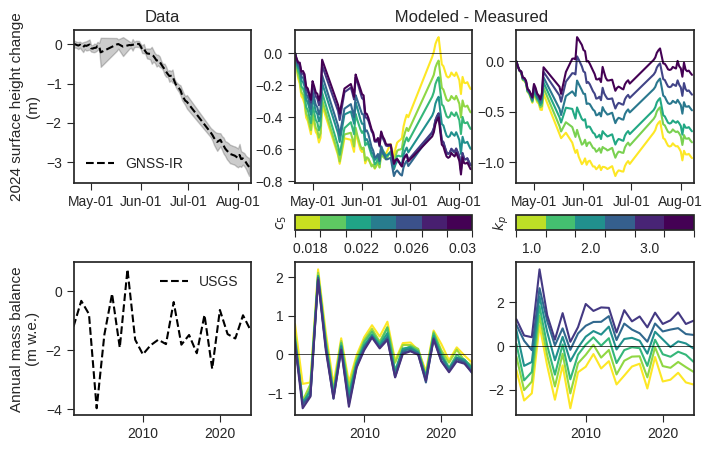

In [60]:
sites = {'long':'B', '2024':'B'}
best_use = ('0.026','2.25') # best_by[-1]
# Pareto front timeseries
fig, axes = plt.subplots(3,3,figsize=(8,5), gridspec_kw={'wspace':0.25, 'hspace':0.3}, height_ratios=(1,0.1,1))
norm = mpl.colors.Normalize(vmin=np.min(all_pareto_kp.astype(float)),vmax=np.max(all_pareto_kp.astype(float)))
cmap = mpl.colormaps.get_cmap('viridis_r')

axes[1,0].axis('off')

# 2024 panels
date = run_info['2024']['date']
idx = run_info['2024']['idx']
site = sites['2024']
# for s, site in enumerate(['T','B','ABB']):
# c = plt.cm.tab10(s)
# Data filepath
fp_gnssir = f'../MB_data/Stakes/gulkana{site}24_GNSSIR.csv'

# Load GNSSIR daily MB
df_mb_dict = {}
if os.path.exists(fp_gnssir):
    df_mb_daily = pd.read_csv(fp_gnssir)
    df_mb_daily.index = pd.to_datetime(df_mb_daily['Date'])
    df_mb_daily['CMB'] -= df_mb_daily['CMB'].iloc[0]
    df_mb_dict['GNSS_IR'] = df_mb_daily.sort_index()

if 'GNSS_IR' in df_mb_dict:
    df_mb_daily = df_mb_dict['GNSS_IR']
    axes[0,0].plot(df_mb_daily.index,df_mb_daily['CMB'],label='GNSS-IR',linestyle='--',color='black')
    # error bounds
    lower = df_mb_daily['CMB'] - df_mb_daily['sigma']
    upper = df_mb_daily['CMB'] + df_mb_daily['sigma']
    axes[0,0].fill_between(df_mb_daily.index,lower,upper,alpha=0.2,color='black')

both_vars = [params['Boone_c5'],params['kp'][::2]]
for j in range(2):
    ax = axes[0,j+1]
    list_plots = []
    param_list = both_vars[j]
    min,max = (np.min(np.array(param_list,dtype=float)),np.max(np.array(param_list,dtype=float)))
    norm =  mpl.colors.Normalize(vmin=min,vmax=max)
    for value in param_list:
        if j == 0:
            c5 = value
            kp = best[1]
        elif j == 1:
            c5 = best[0]
            kp = value
        date = run_info['2024']['date']
        idx = run_info['2024']['idx']
        setno = result_dict[c5][kp][site]['2024_set_no']
        runno = result_dict[c5][kp][site]['2024_run_no']
        ds,s,e = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{setno}_run{runno}_0.nc')
        time,model,data = cumulative_mass_balance(ds,out='data')
        diff = model - data
        ax.plot(time,diff,color=cmap(norm(float(value))),label=value)
    ax.axhline(0,color='k',linewidth=0.5)
    title = '$c_5$' if j == 0 else '$k_p$'
    value = '0.032' if j == 0 else '4'
    boundaries = np.append(np.array(param_list,dtype=float),value).astype(float)
    ticks = copy.deepcopy(boundaries).astype(str)
    ticks[1::2] = ''
    if j == 1:
        ticks[-1] = ''
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=axes[1,j+1],
                  orientation='horizontal',
                  boundaries=boundaries,ticks=boundaries,
                  spacing='proportional') # ,title=title
    cb.ax.set_xticklabels(['        '+t for t in ticks])
    cb.ax.set_ylabel(title)
    ax.set_ylabel('')

# Best 2024 run
# c5,kp = best_use
# setno = result_dict[str(c5)][str(kp).replace('.0','')][site]['2024_set_no']
# runno = result_dict[str(c5)][str(kp).replace('.0','')][site]['2024_run_no']
# ds,_,_ = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{setno}_run{runno}_0.nc')
# time,model,data = cumulative_mass_balance(ds,out='data')
# axes[0,0].plot(time, model, color='red',label= 'Best 2024 parameters')
# axes[0,1].axhline(0,color='k',linewidth=0.5)

site = sites['long']

# annual panels
date = run_info['long']['date']
idx = run_info['long']['idx']
# for s, site in enumerate(['T','B','ABB']):
# c = plt.cm.tab10(s)
dummy,_,_ = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set0_run0_0.nc')
years,_,_,_,_,_,annual_data = seasonal_mass_balance(dummy, out='data')
axes[2,0].plot(years, annual_data,label='USGS',linestyle='--',color='black')

for j in range(2):
    ax = axes[2,j+1]
    list_plots = []
    param_list = both_vars[j]
    norm =  mpl.colors.Normalize(vmin=0,vmax=len(param_list))
    for i,value in enumerate(param_list):
        if j == 0:
            c5 = value
            kp = best[1]
        elif j == 1:
            c5 = best[0]
            kp = value
        date = run_info['long']['date']
        idx = run_info['long']['idx']
        setno = result_dict[c5][kp][site]['set_no']
        runno = result_dict[c5][kp][site]['run_no']
        ds,s,e = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{setno}_run{runno}_0.nc')
        time,_,_,_,_,model,data = seasonal_mass_balance(ds,out='data')
        diff = model - data
        ax.plot(time,diff,color=cmap(norm(i)),label=value)
    ax.set_ylabel('')
    ax.axhline(0,color='k',linewidth=0.5)
    # ax.legend(handles=list_plots,fontsize=10,title=title)

# Best annual run
# c5,kp = best_use
# setno = result_dict[str(c5)][str(kp).replace('.0','')][site]['set_no']
# runno = result_dict[str(c5)][str(kp).replace('.0','')][site]['run_no']
# ds,_,_ = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{setno}_run{runno}_0.nc')
# years,_,_,_,_,annual_model,annual_data = seasonal_mass_balance(ds,out='data')
# axes[2,0].plot(years, annual_model, color='red', label= 'Best annual MB parameters')
# axes[2,1].axhline(0,color='k',linewidth=0.5)

for ax in [axes[0,1],axes[0,0],axes[0,2]]:
    ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-09'))
for ax in [axes[2,0],axes[2,1],axes[2,2]]:
    ax.set_xlim(2001,2024)
for ax in [axes[0,0],axes[2,0]]:
    ax.legend()
for ax in axes.flatten():
    ax.tick_params(length=5)
axes[0,0].set_title('Data')
axes[0,1].set_title('                                      Modeled - Measured')
axes[0,0].set_ylabel('2024 surface height change\n(m)',fontsize=11)
axes[2,0].set_ylabel('Annual mass balance\n(m w.e.)',fontsize=11)

plt.show()

In [43]:
print(len(all_pareto_fronts_flat))

15


In [83]:
best_use = ('0.026','2.5')

Site AB internal acc: 0.00012 m w.e.
Site B internal acc: 0.00003 m w.e.
Site D internal acc: 0.07510 m w.e.
Site T internal acc: 0.06755 m w.e.


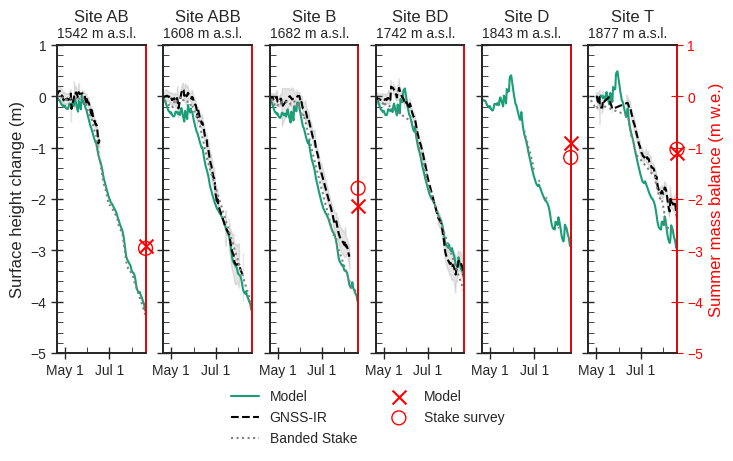

In [84]:
elev = {'AB':1542,'ABB':1608,'B':1682,'BD':1742,'D':1843,'T':1877}
ylim = (-5,1)
c5,kp = best_use
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0.2})
date = run_info['2024']['date']
idx = run_info['2024']['idx']
best_setno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['2024_set_no']
best_runno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['2024_run_no']
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
    ds,s,e = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{best_setno}_run{best_runno}_0.nc')

    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i] = plot_2024_mass_balance(ds,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12,y=1.05)
    axes[i].text(pd.to_datetime('2024-04-20'),1.15,str(elev[site])+' m a.s.l.',fontsize=10)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    
    axes[i].get_legend().remove()
    axes[i].set_xlim(s,e)
    axes[i].set_xticks(pd.date_range(s,e,freq='2MS'))
    axes[i].tick_params(labelsize=10,direction='inout',length=8)
    axes[i].minorticks_on()
    axes[i].tick_params(which='minor', direction='in', length=4)
    axes[i].set_xticklabels(['May 1','Jul 1'])
    axes[i].xaxis.set_minor_locator(mpl.dates.MonthLocator(interval=1))
    twinax = axes[i].twinx()
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(ds,out='mbs')
        mod = twinax.scatter(e,mbmod,color='red',marker='x',s=100)
        meas = twinax.scatter(e,mbmeas,color='red',marker='o',facecolors='none',s=100)
        meas.set_clip_on(False)
        mod.set_clip_on(False)
    twinax.set_ylim(ylim)
    twinax.yaxis.set_ticks_position('right')
    for ss,spine in enumerate(twinax.spines.values()):
        if ss == 1:
            spine.set_edgecolor('red')
    if site=='T':
        twinax.tick_params(labelright=True,labelsize=10,direction='inout',length=8,labelcolor='red',colors='red')
        twinax.set_ylabel('Summer mass balance (m w.e.)',fontsize=12,color='red')
    else:
        twinax.set_yticklabels([])
for ax in axes:
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.set_ylim((ylim))
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
l1, = axes[-1].plot(np.nan,np.nan,color=plt.cm.Dark2(0))
l2, = axes[-1].plot(np.nan,np.nan,color='black',linestyle='--')
l3, = axes[-1].plot(np.nan,np.nan,color='gray',linestyle=':')
leg = fig.legend([l1,l2,l3,mod,meas],['Model','GNSS-IR','Banded Stake','Model','Stake survey'],ncols=2,fontsize=10,bbox_to_anchor=(0.7,0.05))
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(1)
plt.savefig(f'../Output/EB/gulkana_dh_02_2025.png',dpi=180,bbox_inches='tight')
plt.show()

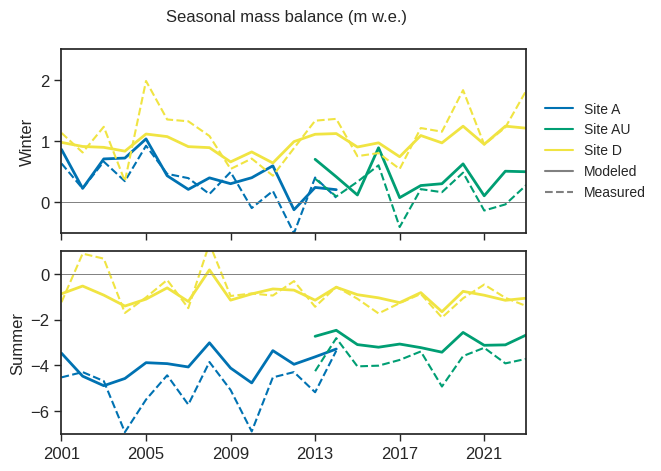

In [87]:
fig, axes = plt.subplots(2,figsize=(6,5),gridspec_kw={'hspace':0.1},sharex=True)
list_plots = []
c5,kp = best_use
sites = ['A','AU','D']
colors = np.flip(['#F0E442','#009E73','#0072B2']) #'#E69F00',
date = run_info['long']['date']
idx = run_info['long']['idx']
best_setno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['set_no']
best_runno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['run_no']

for ss,site in enumerate(sites):   
    ds,s,e = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{best_setno}_run{best_runno}_0.nc')

    color = colors[ss]
    axes[0] = plot_seasonal_mass_balance(ds,plot_ax=axes[0],plot_var='bw',color=color)
    axes[1] = plot_seasonal_mass_balance(ds,plot_ax=axes[1],plot_var='bs',color=color)
    dummy_site, = axes[1].plot(np.nan,np.nan,color=color)
    list_plots.append(dummy_site)
dummy_model, = axes[1].plot(np.nan,np.nan,color='gray')
dummy_meas, = axes[1].plot(np.nan,np.nan,color='gray',linestyle='--')
list_plots.append(dummy_model)
list_plots.append(dummy_meas)
axes[0].set_ylabel('Winter',fontsize=12)
axes[1].set_ylabel('Summer',fontsize=12)
axes[0].set_ylim(-0.5,2.5)
axes[1].set_ylim(-7,1)
axes[1].set_yticks([0,-2,-4,-6])
for i in range(2):
    axes[i].get_legend().remove()
labels = ['Site '+sss for sss in sites]+['Modeled','Measured']
fig.legend(list_plots,labels,bbox_to_anchor=(1.12,0.8),fontsize=10)
fig.suptitle('Seasonal mass balance (m w.e.)',fontsize=12,y=0.96)
# plt.savefig(base_fp+'seasonal_mass_balance.png',dpi=180,bbox_inches='tight')
plt.savefig('../Output/EB/gulkana_seasonal_02_2025.png',dpi=180,bbox_inches='tight')
plt.show()

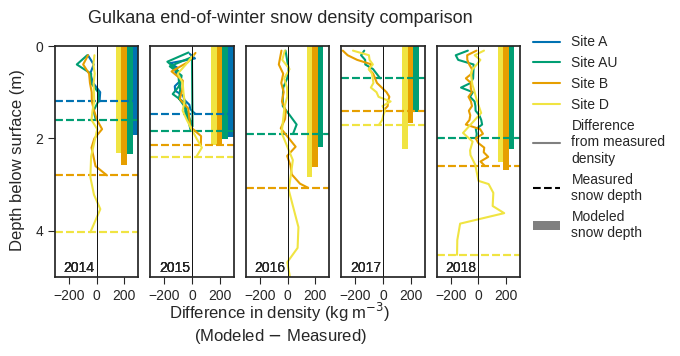

In [88]:
plot_diff = True
# years = np.arange(2000,2025)
years = np.arange(2014,2019)
with open('../MB_data/pits.pkl', 'rb') as file:
    site_profiles = pickle.load(file)
ds_by_site = {'A':[],'AU':[],'B':[],'D':[]}
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) # 
fig,axes = plt.subplots(1,5,figsize=(6,3),sharex=True,sharey=True,gridspec_kw={'hspace':0.12,'wspace':0.15})
axes = axes.flatten()
date = run_info['long']['date']
idx = run_info['long']['idx']
best_setno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['set_no']
best_runno = result_dict[str(c5)][str(kp).replace('.0','')]['B']['run_no']

for ss,site in enumerate(sitedict['long']):   
    ds,s,e = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{best_setno}_run{best_runno}_0.nc')
    color = colors[ss]

    # Load data for the site
    profiles = site_profiles[site]

    # Loop through years
    for y,year in enumerate(years):
        ax = axes[y]

        # Some years don't have data: skip
        if year in profiles['sbd']:
            # Load data
            sbd = profiles['sbd'][year]
            dens_meas = profiles['density'][year]

            # Load dataset on the date the snowpit was taken
            sample_date = profiles['date'][year]
            dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))

            # Add year to the axis
            coords = [-240,4.9] if plot_diff else [50,4.9]
            ax.text(coords[0],coords[1],str(year),fontsize=10)

            # Calculate layer density and determine snow indices
            ldz = dsyear.layerheight.values
            depth_mod = np.array([np.sum(ldz[:i+1])-(ldz[i]/2) for i in range(len(ldz))])
            dens_mod = dsyear['layerdensity'].values
            snow_idx = np.where(depth_mod < dsyear.snowdepth.values)[0]

            if plot_diff:
                # Interpolate modeled density to the snowpit depths
                dens_interp = np.interp(sbd,depth_mod,dens_mod)
                diff = dens_interp - dens_meas

                # Plot the difference
                ax.plot(diff,profiles['sbd'][year],color=color)
            else:
                # Plot the profiles
                ax.plot(dens_meas,sbd,color=color,linestyle='--')
                ax.plot(dens_mod[snow_idx],depth_mod[snow_idx],color=color)

            # Find the snow depth
            snowdepth_mod = depth_mod[snow_idx[-1]]
            snowdepth_pit = sbd[~np.isnan(sbd)][-1]

            # Plot a horizontal line for the snow depth
            # ax.axhline(snowdepth_mod,color=color)
            ax.axhline(snowdepth_pit,color=color,linestyle='--')            

            if plot_diff:
                # Plot a bar of the snow depth
                bar_width = 40
                ax.bar(300-(ss+1)*bar_width,snowdepth_mod,width=bar_width,color=color,align='edge')
                ax.axhline(snowdepth_pit,color=color,linestyle='--')

    # Dummy variable for legend
    axes[4].plot(np.nan,np.nan,label=f'Site {site}',color=color)

# Dummy variables for legend
if plot_diff:
    axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
    axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
    axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')
else:
    axes[4].plot(np.nan,np.nan,label='Modeled',color='grey')
    axes[4].plot(np.nan,np.nan,label='Measured',color='gray',linestyle='--')

# Format axes
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(5,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    if plot_diff:
        ax.axvline(0,color='k',linewidth=0.5)
        ax.set_xlim(-300,300)
        ax.set_xticks([-200,0,200])
        fig.supxlabel('Difference in density (kg m$^{-3}$)\n(Modeled $-$ Measured)',fontsize=12,y=-0.12)
    else:
        ax.set_xlim(0,600)
        ax.set_xticks([0,250,500])
        fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.04)
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    ax.axvline(0,linewidth=0.5,color='black')
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
axes[4].legend(bbox_to_anchor=(1,1.1))
fig.suptitle(f'Gulkana end-of-winter snow density comparison',fontsize=13,y=1)
plt.savefig('../Output/EB/density_pits_02_2025.png',dpi=180,bbox_inches='tight')
plt.show()

%H:%M %d


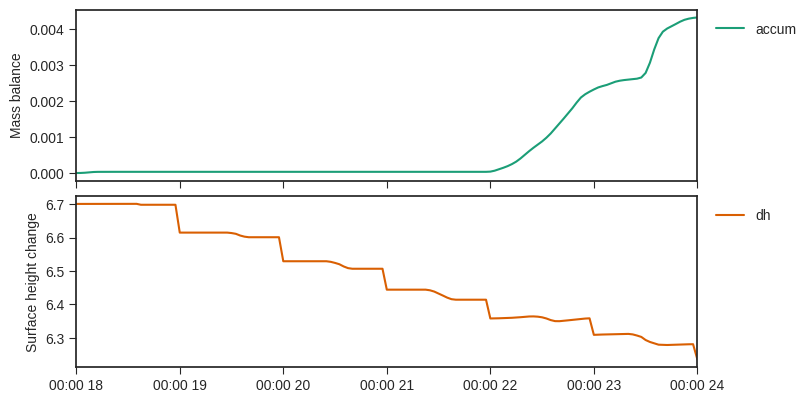

In [63]:
# visualize_layers(bds,pd.date_range('2024-04-18','2024-05-01',freq='h'),['layertemp','layerdensity','layerwater'])
fig,(_,ax) = simple_plot(ds,[s,'2024-04-24'],[['accum'],['dh']],res='h',date_form='%H:%M %d')
plt.show()